# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")
random_state = 42

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

Loss function matrix form: $$ \nabla_wL(w) = -y\log\sigma(Xw) - (1 - y)\log(1 - \sigma(Xw)) + \gamma||w||_1 + \beta||w||_2^2 $$
Gradient function with sum: $$ \nabla_wL(w) = \sum_{ i = 1 }^{ N }x_i(\sigma(w^tx_i) - y_i) + \gamma\operatorname{ sign }(w) + 2\beta w $$
Gradient function matrix form: $$ \nabla_wL(w) = (\sigma(Xw) - y) X + \gamma\operatorname{ sign }(w) + 2\beta w $$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [2]:
from numpy.linalg import norm
sigmoid = lambda x: 1 / (1 + np.exp(-x))

In [284]:
def loss(X, y, w: List[float], gamma=1., beta=1.) -> float: # l1 = np.linalg.norm (x, ord=1) # l2 = np.linalg.norm (x)
    return np.dot(-y, np.log(sigmoid(X.dot(w.T)))) - np.dot(1 - y, np.log(1 - sigmoid(X.dot(w.T)))) + gamma*norm(w, 1) + beta*norm(w)**2

#### 3. [0.25 points] Implement the gradient (as a function)

In [365]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    return (sigmoid(w.dot(X.T)) - y).dot(X) + gamma*np.sign(w) + 2*beta*w

#### Check yourself

In [247]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [246]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [473]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=random_state, criteria=0.5):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.w = None
        self.loss_history = None
        self.criteria = criteria
        self.lr = lr
        self.classes_ = None
        # you may additional properties if you wish

    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        def stop_condition(current_iter, last_w):
            norm = np.linalg.norm(self.w - last_w)
            return current_iter < self.max_iter and norm > self.tolerance or current_iter == 0

        self.classes_ = np.unique(y)
        
        X = np.c_[np.ones(X.shape[0]), X]

        if self.w is None:
            self.w = np.random.normal(size=X.shape[1])
            
        last_w = self.w.copy()
        current_iter = 0 
        self.loss_history = []

        while stop_condition(current_iter, last_w):
                current_iter += 1
                last_w = self.w.copy()
                
                gradient = get_grad(X, y, self.w, gamma=self.gamma, beta=self.beta)
            
                self.w = self.w - self.learning_rate * gradient
            
                self.loss_history.append(loss(X, y, self.w, gamma=self.gamma, beta=self.beta))            
        
        return self

    def predict(self, X):
        # return vector of predicted labels (0 or 1) for each object from X
        if self.w is None:
            raise Exception('Not trained yet')
            
        X = np.c_[np.ones(X.shape[0]), X]
        return np.where(sigmoid(np.dot(X, self.w.T)) < self.criteria, 0, 1) 

    def predict_proba(self, X):
      # return vector of probabilities for each object from X
        X = np.c_[np.ones(X.shape[0]), X]

        return np.array([1 / (1 + np.exp(np.dot(X, self.w.T))),\
                         1 / (1 + np.exp(-np.dot(X, self.w).T))])

In [500]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=random_state, n_clusters_per_class=1)

In [88]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y, criteria):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)
    
    fig.suptitle(f'Criteria {criteria}')

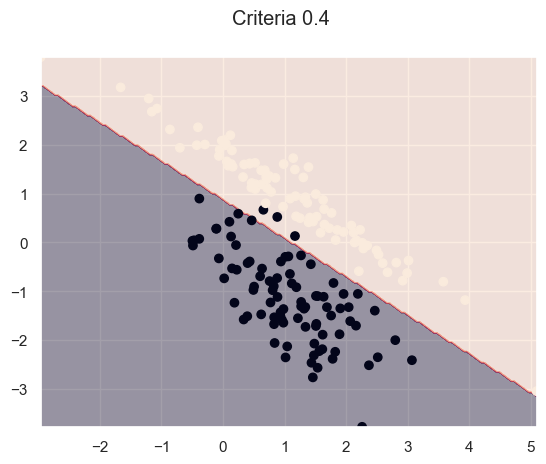

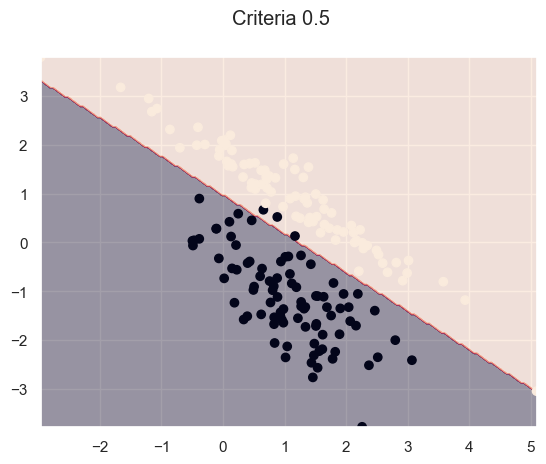

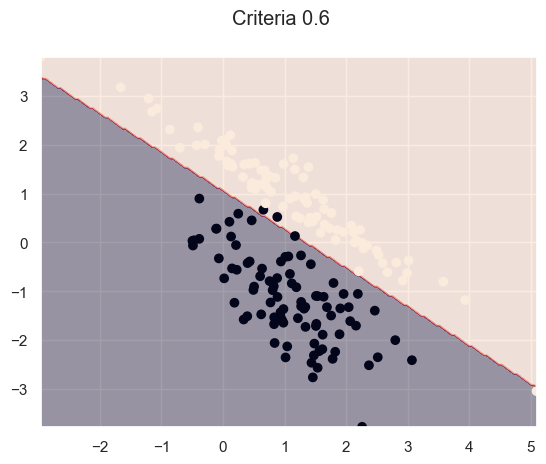

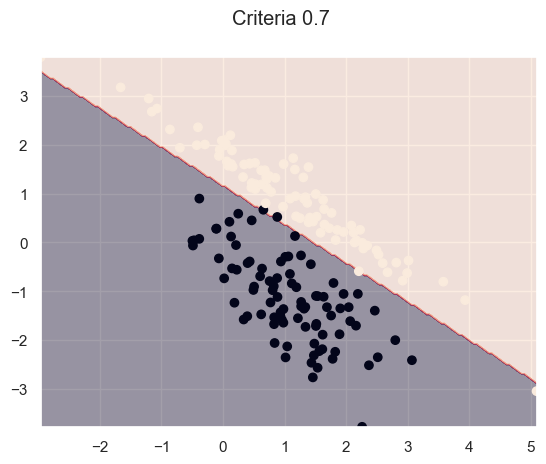

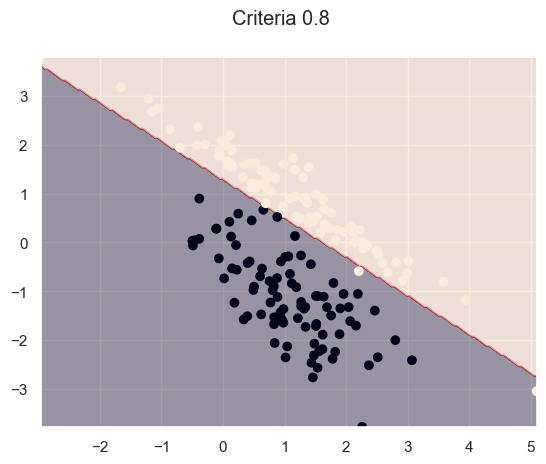

In [385]:
for criteria in [i / 10 for i in range(4, 9)]:
    model = Logit(criteria=criteria, tolerance=1e-4, max_iter=5000, beta=1e-4)
    model.fit(X, y)
    plot_decision_boundary(model, X, y, criteria)

### Тут можно заметить, что лучшим значением порога принадлежности будет 0.6. Кроме того, я заметил, что параметер beta меняет угол наклона графика, потому я выбрал для него значение 10^-4

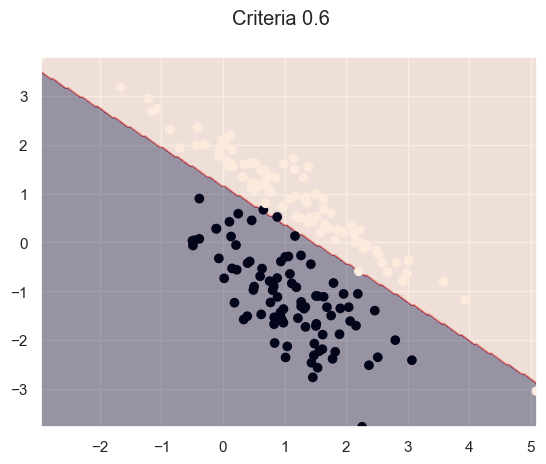

In [238]:
model = Logit(criteria=0.7, tolerance=1e-4, max_iter=5000, beta=1e-4)
model.fit(X, y)
plot_decision_boundary(model, X, y, 0.6)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

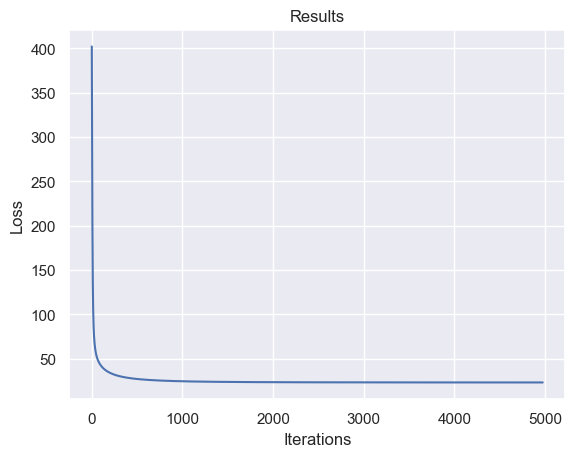

In [12]:
from matplotlib.collections import EventCollection

# plot the data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(range(len(model.loss_history)), model.loss_history)

ax.set_title('Results')
plt.xlabel("Iterations")
plt.ylabel("Loss")

# display the plot
plt.show()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [13]:
scoring = { 'Accuracy': 'accuracy', 'roc_auc': 'roc_auc', 'f1': 'f1' }
kernels = ('linear', 'poly', 'rbf', 'sigmoid')
Cs = [ 10**_ for _ in range(-3, 3) ]
gammas = ('scale', 'auto') # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. 
coef0 = (0, 1) # It is only significant in ‘poly’ and ‘sigmoid’.
class_weight = [ 'balanced', None ]

parameters = { 'kernel': kernels, 'C': Cs , 'gamma': gammas, 'coef0': coef0, 'class_weight' : class_weight } 

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

svс = SVC(probability=True, verbose=False)
classifier = GridSearchCV(svс, parameters, scoring=scoring, refit='Accuracy', verbose=2, cv=2)

classifier.fit(X, y)
results = pd.DataFrame(classifier.cv_results_)

Fitting 2 folds for each of 192 candidates, totalling 384 fits
[CV] END C=0.001, class_weight=balanced, coef0=0, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, coef0=0, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, coef0=0, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, coef0=0, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, coef0=0, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, coef0=0, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, coef0=0, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, coef0=0, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, coef0=0, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, coef0=0, gamma=auto, kernel=line

In [15]:
results[(results.mean_test_Accuracy == 1) & (results.mean_test_roc_auc == 1)
    & (results.mean_test_f1 == 1)][['param_C', 'param_coef0', 'param_gamma', 'param_class_weight','param_kernel']]

param_C param_coef0 param_gamma param_class_weight param_kernel
109       1           1        auto           balanced         poly
125       1           1        auto               None         poly
137      10           1       scale           balanced         poly
141      10           1        auto           balanced         poly
153      10           1       scale               None         poly
157      10           1        auto               None         poly
162     100           0       scale           balanced          rbf
169     100           1       scale           balanced         poly
170     100           1       scale           balanced          rbf
173     100           1        auto           balanced         poly
178     100           0       scale               None          rbf
185     100           1       scale               None         poly
186     100           1       scale               None          rbf
189     100           1        auto               None         poly

### Вот они, слева направо (сверху вниз, но не важно), лучшие параметры для модели на заданных данных. Не трудно заметить, что большинство из этих моделей использовали полиномиальное ядро, coef0 = 1, C = 100. Про gamma ничего особо точно сказать не получится, так как их почти поровну, так же как и class_weight.

In [659]:
import itertools

def show_graps(param, res_data):
    
    fig, axs = plt.subplots(1, 3)
    
    for kernel in results.param_kernel.unique():
        data = res_data[res_data.param_kernel == kernel]
        
        fig.suptitle('Param: C')
        axs[0].set_title('Accuracy')
        axs[0].plot(data[param], data.mean_test_Accuracy, label=kernel)
        axs[0].set_xscale('log')
    
        axs[1].set_title('ROC-AUC')
        axs[1].plot(data[param], data.mean_test_roc_auc, label=kernel)
        axs[1].set_xscale('log')
    
        axs[2].set_title('F1')
        axs[2].plot(data[param], data.mean_test_f1, label=kernel)
        axs[2].set_xscale('log')
    
    handles, labels, = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=2)
    fig.tight_layout()
    fig.set_size_inches(18.5, 10.5)

In [657]:
from sklearn.metrics import confusion_matrix

svс = SVC(probability=True, verbose=False)
classifier = GridSearchCV(svс, { 'kernel': kernels, 'C':  [ 10**_ for _ in range(-5, 5) ] } , scoring=scoring, refit='Accuracy', verbose=2, cv=2)
classifier.fit(X, y)
results_C = pd.DataFrame(classifier.cv_results_)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV] END .............................C=1e-05, kernel=linear; total time=   0.0s
[CV] END .............................C=1e-05, kernel=linear; total time=   0.0s
[CV] END ...............................C=1e-05, kernel=poly; total time=   0.0s
[CV] END ...............................C=1e-05, kernel=poly; total time=   0.0s
[CV] END ................................C=1e-05, kernel=rbf; total time=   0.0s
[CV] END ................................C=1e-05, kernel=rbf; total time=   0.0s
[CV] END ............................C=1e-05, kernel=sigmoid; total time=   0.0s
[CV] END ............................C=1e-05, kernel=sigmoid; total time=   0.0s
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END ..............................C=0.0001, kernel=poly; total time=   0.0s
[CV] END ..............................C=0.0001,

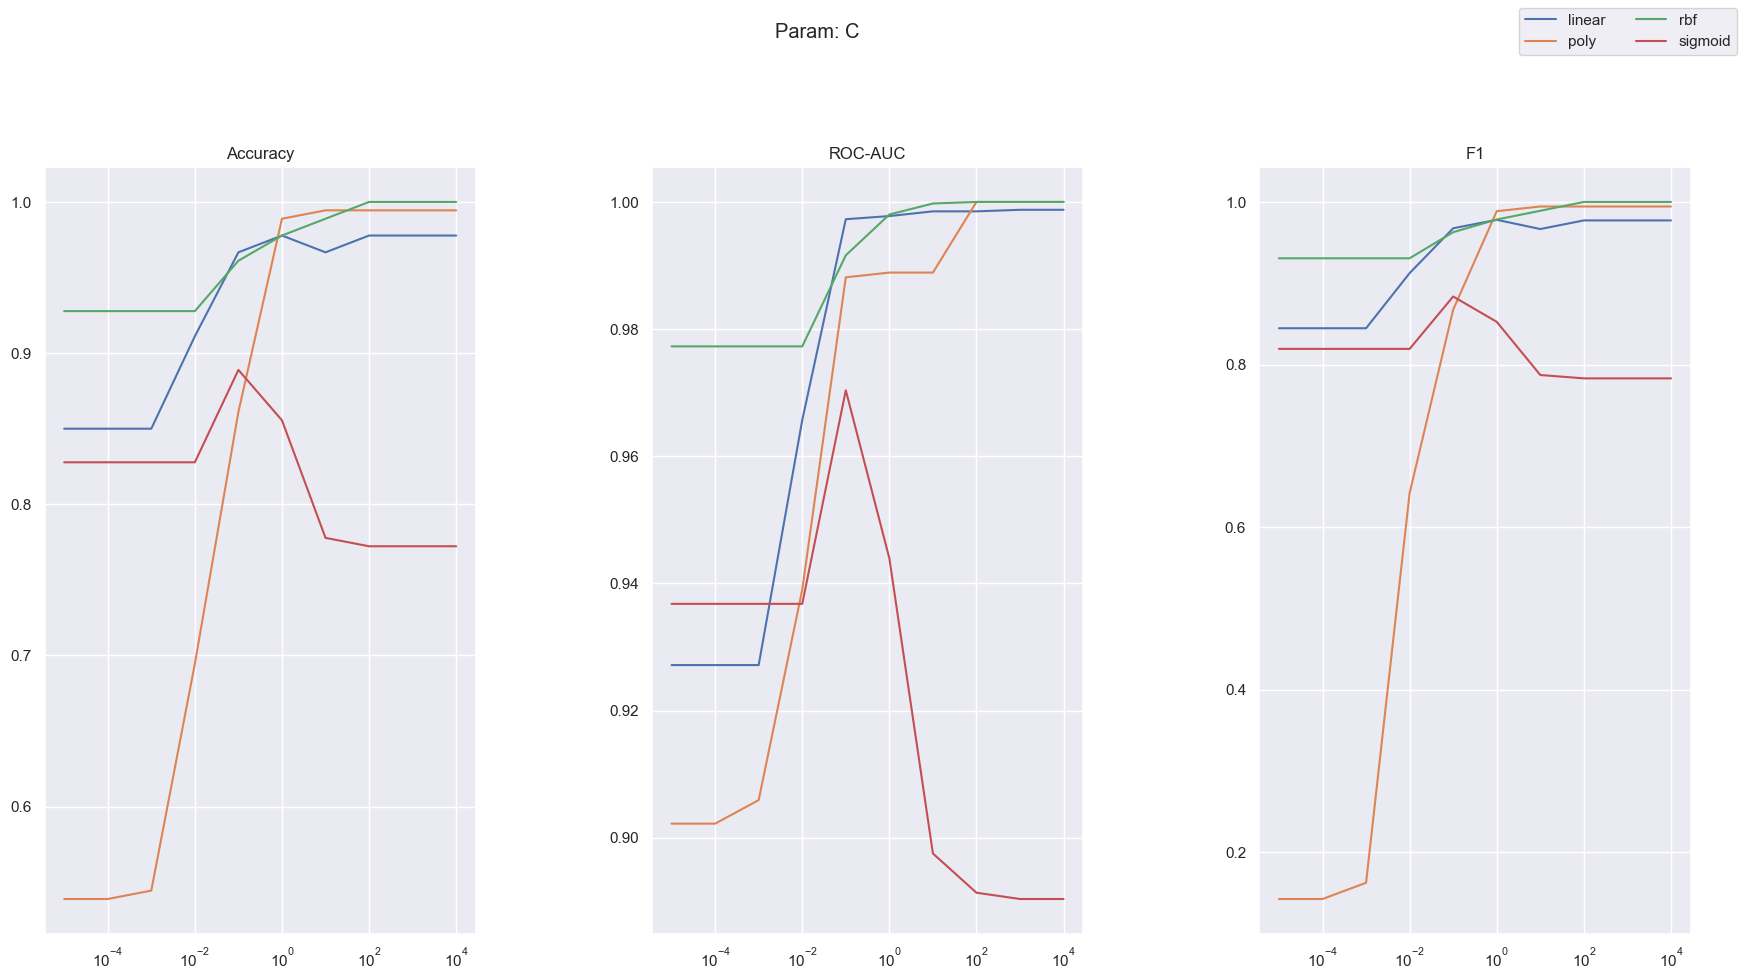

In [660]:
show_graps('param_C', results_C)

### Вывод: как можно заметить, некоторые ядра очень сильно подверженые влиянию гиперпараметров, а именно полиномиальное и сигмоидное, их графики очень сильно изменяются по мере изменения гиперпараметров. На линейное и радиальное ядра влияние оказывается меньше. Самым стойким к переобучению очевидно оказалось ядро rbf.

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

### **Subpart 1** - building a dataset

#### Я выбрал писателей: Брюсов, Достоевский, Толстой, Горький, Пушкин, Чехов

In [17]:
proportion = [5000, 15000, 8000, 11000, 20000, 3000]
proportion.sort(reverse=True)
path_to_dataset = './dataset'
max_len = 15

In [18]:
import os, re, nltk

def get_dataset(path):
    tokenizer = nltk.PunktSentenceTokenizer()
    dataset = []
    for dir in os.listdir(path):
        cur_dir = os.path.join(path, dir)
        if os.path.isdir(cur_dir):
            for file in os.listdir(cur_dir):
                with open(os.path.join(cur_dir, file), encoding='utf8') as f:
                    dataset += [ (sentence, dir) for sentence in tokenizer.tokenize(f.read().replace('\n', ' ')) ]
                    
    return pd.DataFrame(dataset, columns=['sentence', 'author'])

In [19]:
data = get_dataset(path_to_dataset)
data = data[data.sentence.str.len() - 1 >= max_len]  # Я не беру в расчет знак препинания в конце предложения
data

sentence       author
0       Максим Горький МАКАР ЧУДРА С моря дул влажный,...      Горький
1       Изредка его порывы приносили с собой сморщенны...      Горький
2       Не обращая внимания на то, что холодные волны ...      Горький
3                                        — Так ты ходишь?      Горький
5                     Ты славную долю выбрал себе, сокол.      Горький
...                                                   ...          ...
342115                            53        защиты (фр.).  Достоевский
342116         54        Дьявола-то больше не существует!  Достоевский
342118   55        шедевр, образцовое произведение (фр.).  Достоевский
342119             56        после меня хоть потоп (фр.).  Достоевский
342120                          57        призываю живых!  Достоевский

[306476 rows x 2 columns]

In [20]:
def split_data(dataset, proportion):
    authors = dataset.value_counts('author').index
    splited_dataset = pd.DataFrame()

    for author, proportion_for_author in zip(authors, proportion):
        author_sentences = dataset[dataset.author == author]
        splited = author_sentences.sample(proportion_for_author, random_state=random_state)
        splited_dataset = pd.concat([splited_dataset, splited])
    
    return splited_dataset

In [21]:
splited_data = split_data(data, proportion)
splited_data

sentence       author
327310  – С Катериной Ивановной худо… Они плачут… исте...  Достоевский
318060  Я  вдруг   почувствовал, что  мне все равно бы...  Достоевский
261499  Влюбленная   девушка была в восторге и в предл...  Достоевский
274435  Как и давеча, Рогожин выступал впереди всех, о...  Достоевский
323625  Старец выслушал ее улыбаясь и с нежностью благ...  Достоевский
...                                                   ...          ...
191158  Около трех недель прошло для меня в хлопотах в...       Пушкин
195502                                  – Тебе како дело?       Пушкин
188674                                — закричал Хлопуша.       Пушкин
193956  «Я не ворон (возразил Пугачев, играя словами и...       Пушкин
189918  Раскрой-ка первый том; читай вслух... Барышня ...       Пушкин

[62000 rows x 2 columns]

### **Subpart 2** - Preprocess the dataset

In [22]:
import string, pymorphy2

morph = pymorphy2.MorphAnalyzer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')
word_tokenizer = nltk.WordPunctTokenizer()
puntuation_digits = string.punctuation + '«…—»–' + '1234567890' # Тут видимо особые символы макоси, добавил их удаление таким образом

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/IlyaVolodin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def preprocess_sentence(sentence):
    tokens = word_tokenizer.tokenize(sentence.lower())
    return ' '.join([ (morph.parse(word)[0].normal_form) # lemmatization
            for word in tokens 
            if (not any(map(lambda c: c in puntuation_digits, word)) and word not in stop_words ) ]) 
    # я сделал "any(map(lambda c: c in puntuation, word))", потому что встречались такие последовательности символов, как "»).", "--" и тд

In [24]:
splited_tokenized_data = splited_data.copy()
splited_tokenized_data.sentence = splited_data.apply(lambda row: preprocess_sentence(row.sentence), axis=1)
splited_tokenized_data

sentence       author
327310     катерина иванович худо плакать истерика биться  Достоевский
318060       почувствовать равно существовать мир б нигде  Достоевский
261499  влюбить девушка восторг предложение версиловый...  Достоевский
274435  давеча рогожина выступать впереди остальной по...  Достоевский
323625  старец выслушать улыбаться нежность благослови...  Достоевский
...                                                   ...          ...
191158  около три неделя пройти хлопоты всякий род воз...       Пушкин
195502                                       ты како дело       Пушкин
188674                                закричать хлопушить       Пушкин
193956  ворон возразить пугачёв играть слово изъяснять...       Пушкин
189918  раскрой ка первый читать вслух барышня взять к...       Пушкин

[62000 rows x 2 columns]

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

max_features = 50

bag_vectorizer = CountVectorizer(max_features = max_features)
bag_vectorizer.fit(splited_tokenized_data.sentence)

tf_idf_vectorizer = TfidfVectorizer(max_features = max_features) 
tf_idf_vectorizer.fit(splited_tokenized_data.sentence)

X_bag = bag_vectorizer.transform(splited_tokenized_data.sentence)
X_tf_idf = tf_idf_vectorizer.transform(splited_tokenized_data.sentence)

In [26]:
print(bag_vectorizer.get_feature_names_out())
X_bag.todense()[:10]

['бог' 'быть' 'ваш' 'весь' 'видеть' 'время' 'всё' 'глаз' 'говорить' 'год'
 'голова' 'дело' 'день' 'должный' 'дом' 'друг' 'другой' 'думать' 'жизнь'
 'жить' 'знать' 'идти' 'казаться' 'какой' 'князь' 'который' 'лицо'
 'любить' 'мой' 'мочь' 'наш' 'один' 'очень' 'первый' 'рука' 'сам' 'самый'
 'свой' 'сделать' 'сказать' 'слово' 'смотреть' 'стать' 'такой' 'тот' 'ты'
 'хотеть' 'человек' 'это' 'этот']


matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 2, 0, 0,

In [27]:
print(tf_idf_vectorizer.get_feature_names_out())
X_tf_idf.todense()[:10]

['бог' 'быть' 'ваш' 'весь' 'видеть' 'время' 'всё' 'глаз' 'говорить' 'год'
 'голова' 'дело' 'день' 'должный' 'дом' 'друг' 'другой' 'думать' 'жизнь'
 'жить' 'знать' 'идти' 'казаться' 'какой' 'князь' 'который' 'лицо'
 'любить' 'мой' 'мочь' 'наш' 'один' 'очень' 'первый' 'рука' 'сам' 'самый'
 'свой' 'сделать' 'сказать' 'слово' 'смотреть' 'стать' 'такой' 'тот' 'ты'
 'хотеть' 'человек' 'это' 'этот']


matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 

### Числа после операции transform показывают статистические меры слов. Но между bag и tf-idf есть большое отличие - bag просто показывает количество вхождения слова в предложение, по сути он чем-то схож с результатом one-hot encoding. Tf-idf же очень похож на target encoding, потому что определяет степень влияния данного слова на результат. Чем более уникальное слово среди документов и чем чаще оно встречается в этих документах, тем большее влияние оно имеет на результат. Идеальный вариант - слово встречается в одном докумнте и в он состоит только из этого слова. Это позволяет придавать меньшее значение словам, которые встечаются повсеместно, что не несет полезной информации и представляет собой своего рода шум. Очевидно, что tf-idf предпочтительнее, чем bag.

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [683]:
two_authors = splited_tokenized_data[ (splited_tokenized_data.author == 'Брюсов') | (splited_tokenized_data.author == 'Чехов') ]
X, y = two_authors.sentence, two_authors.author
splited_tokenized_data.author.value_counts()

author
Достоевский    20000
Толстой        15000
Горький        11000
Брюсов          8000
Чехов           5000
Пушкин          3000
Name: count, dtype: int64

### Классы сбалансированы (а чего еще ожидать, сами же делили)

In [684]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, [1 if i == y.iloc[0]  else 0 for i in y ], test_size=0.3, random_state=random_state)

In [30]:
params_for_grad = { key: parameters[key] for key in ['kernel', 'C', 'class_weight'] }

In [31]:
from sklearn.metrics import f1_score

word_grid = [ 100, 1000, 10000, None ]
grad_f1s = []
best_parameters_svc = None
    
for max_features in word_grid:
    vectorizer = TfidfVectorizer(max_features = max_features)
    vectorizer.fit(X_train)
    transformed_X_train = vectorizer.transform(X_train)
    transformed_X_test  = vectorizer.transform(X_test)
        
    svс = SVC(probability=True, verbose=False)
    classifier = GridSearchCV(svс, params_for_grad, scoring='f1', n_jobs=-1)
    classifier.fit(transformed_X_train, y_train)

    f1 = classifier.best_score_
    
    print('Number of features: ', max_features)
    print("F1-measure: {0:6.2f}".format(f1))
    grad_f1s.append(f1)

    if best_parameters_svc is None or f1 > best_parameters_svc[1]:
        best_parameters_svc = (classifier.best_params_, f1 if max_features != None else vectorizer.get_feature_names_out().shape[0])

Number of features:  100
F1-measure:   0.77
Number of features:  1000
F1-measure:   0.81
Number of features:  10000
F1-measure:   0.86
Number of features:  None
F1-measure:   0.86


In [32]:
best_parameters_svc

({'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}, 0.8577092622505356)

In [388]:
params_for_logit = { 'criteria' : [ _/10 for _ in range(4, 7) ], 'tolerance' : [ 0.01, 0.001, 0.0001 ] } | { 'max_iter' : [ 1000 ] }

In [389]:
logit_f1s = []
best_parameters_logit = None 

for max_features in word_grid:
    vectorizer = TfidfVectorizer(max_features = max_features)
    vectorizer.fit(X_train)
    transformed_X_train = vectorizer.transform(X_train)
    transformed_X_test  = vectorizer.transform(X_test)
        
    logit = Logit()
    classifier = GridSearchCV(logit, params_for_logit, scoring='f1', n_jobs=-1)
    classifier.fit(transformed_X_train.todense(), np.array(y_train))

    f1 = classifier.best_score_
    
    print('Number of features: ', max_features)
    print("F1-measure: {0:6.2f}".format(f1))
    logit_f1s.append(f1)

    if best_parameters_logit is None or f1 > best_parameters_logit[1]:
        best_parameters_logit = (classifier.best_params_, f1 if max_features != None else vectorizer.get_feature_names_out().shape[0])

Number of features:  100
F1-measure:   0.77


/opt/homebrew/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Number of features:  1000
F1-measure:   0.81
Number of features:  10000
F1-measure:   0.80
Number of features:  None
F1-measure:   0.79


In [445]:
best_parameters_logit

({'criteria': 0.5, 'max_iter': 1000, 'tolerance': 0.0001}, 0.8071193190158997)

In [415]:
vectorizer = TfidfVectorizer(max_features=None)
vectorizer.fit(X_train)

word_grid[-1] = vectorizer.get_feature_names_out().shape[0]

Text(0.5, 1.0, 'F1 result of logit')

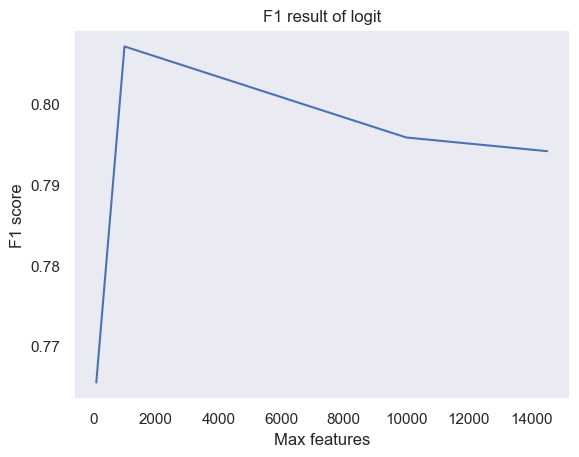

In [427]:
plt.plot(word_grid, logit_f1s) 
plt.grid() 
plt.xlabel('Max features')
plt.ylabel('F1 score')
plt.title('F1 result of logit')

Text(0.5, 1.0, 'F1 result of svc')

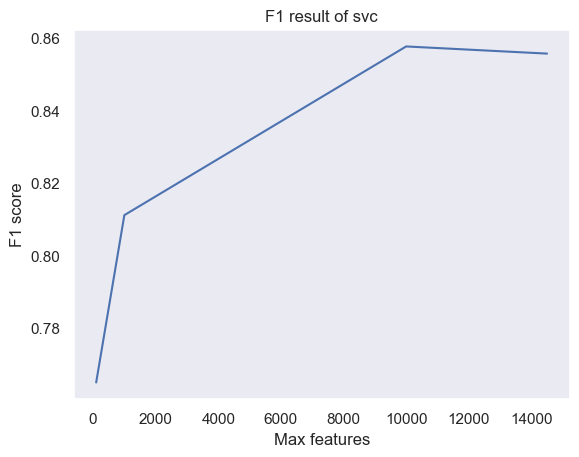

In [424]:
plt.plot(word_grid, grad_f1s) 
plt.grid() 
plt.xlabel('Max features')
plt.ylabel('F1 score')
plt.title('F1 result of svc')

### Взял из семинара, не бейте плиз

In [496]:
from sklearn.metrics import *

def show_results(test_y, pred, proba): 
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro'))) 
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro'))) 
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro'))) 
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred))) 
    print("ROC-AUC = {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),)) 
    print('\n') 
    labels = [y.iloc[0],y[y != y.iloc[0]].iloc[0]] #classification_report 
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels) 
    plt.title("Confusion matrix ") 
    plt.show()

In [685]:
vectorizer = TfidfVectorizer(max_features = 10000)
vectorizer.fit(X_train)
transformed_X_train = vectorizer.transform(X_train)
transformed_X_test  = vectorizer.transform(X_test)

svc = SVC(probability=True, verbose = False, C=10, class_weight='balanced', kernel='rbf')
svc.fit(transformed_X_train, y_train)

SVC(C=10, class_weight='balanced', probability=True)

Precision:   0.81
Recall:   0.80
F1-measure:   0.80
Accuracy:   0.82
ROC-AUC =   0.89




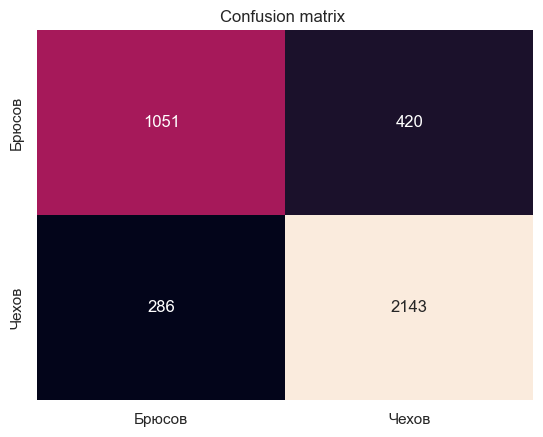

In [678]:
show_results(y_test, svc.predict(transformed_X_test), svc.predict_proba(transformed_X_test))

In [452]:
logit = Logit(criteria=0.5, max_iter=1000, tolerance=0.0001)
logit.fit(transformed_X_train.todense(), np.array(y_train))

Logit(tolerance=0.0001)

Precision:   0.78
Recall:   0.56
F1-measure:   0.50
Accuracy:   0.66
ROC-AUC =   0.84




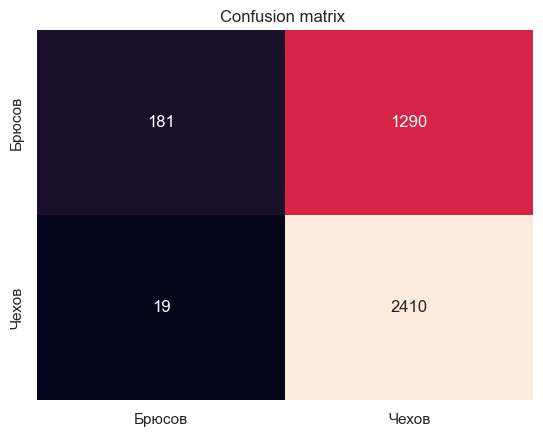

In [498]:
proba = logit.predict_proba(transformed_X_test.todense())

show_results(y_test, logit.predict(transformed_X_test.todense()), proba.reshape(proba.shape[0], proba.shape[1]).T)

### Вывод - в целом, вышли не плохие результаты, правда моя модель скорее всего не дообучилась или наоборот переобучилась. По производительности - треш, по какой-то причине моя модель Logit очень долго работала, приблизительно час, как и SVC. По поводу метрик - в целом SVC очень даже хороший результат по обеим. А вот Logit, имея в целом неплохую точность сильно пострадала на покрытии, что сказалось на f-мере. Но тем не менее, roc_auc получился неплохим, значит в целом модель не плохая. 

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

1.0

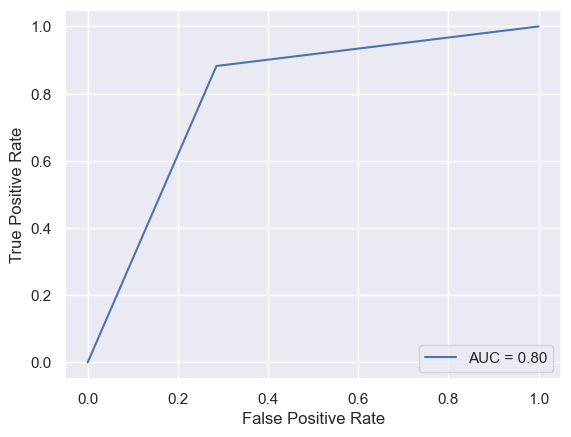

In [702]:
from sklearn import metrics

fpr_svc, tpr_svc, thresholds_svc = metrics.roc_curve(y_test, np.array(svc.predict(transformed_X_test)))
roc_auc_svc = metrics.auc(fpr, tpr)

display_svc = metrics.RocCurveDisplay(fpr=fpr_svc, tpr=tpr_svc, roc_auc=roc_auc_svc)
display_svc.plot()
thresholds_svc[1]

inf

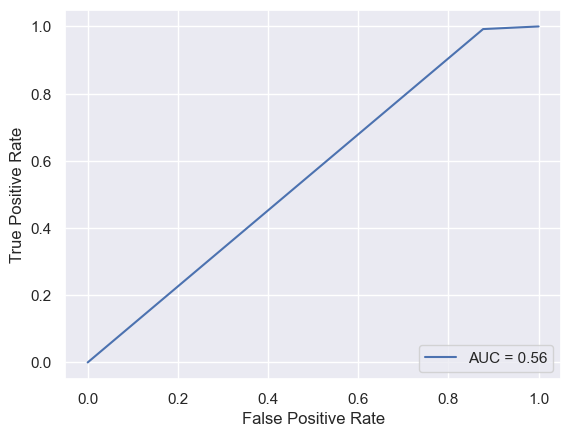

In [704]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, np.array(logit.predict(transformed_X_test.todense())))
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)

display_lr = metrics.RocCurveDisplay(fpr=fpr_lr, tpr=tpr_lr, roc_auc=roc_auc_lr)
display_lr.plot()
thresholds_lr[0]

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [681]:
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(splited_tokenized_data.sentence, splited_tokenized_data.author
                                                    , test_size=0.3, random_state=random_state, stratify=splited_tokenized_data.author)
vectorizer = TfidfVectorizer(max_features = 100)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

print(Counter(y_train))

for author, i in zip(splited_tokenized_data.author.unique(), range(len(splited_tokenized_data.author.unique()))):
    y_train[y_train == author] = i
    y_test[y_test == author] = i

Counter(y_train)

Counter({'Достоевский': 14000, 'Толстой': 10500, 'Горький': 7700, 'Брюсов': 5600, 'Чехов': 3500, 'Пушкин': 2100})


Counter({0: 14000, 1: 10500, 2: 7700, 3: 5600, 4: 3500, 5: 2100})

In [682]:
ooc = OneVsOneClassifier(Logit())
ooc.fit(X_train, y_train)

ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.